In [6]:
import pandas as pd
import shutil
import geopandas as gpd
import xgboost as xgb
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import mean_absolute_error as mae ,r2_score ,explained_variance_score,max_error,mean_squared_error,mean_absolute_percentage_error,median_absolute_error,mean_gamma_deviance


In [7]:
import shap

In [48]:
import numpy as np

In [8]:
shap.initjs()

In [9]:
df = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/02. jkk_bsls_densenet_sls_sentinel_train.csv")
df_test = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/02. jkk_bsls_densenet_sls_sentinel_test.csv")
X = df.drop(["jk","idsls","klas_ur","luas"],axis = 1)
y = df.jk
X= X*100

In [10]:
xgb_model_basic = xgb.XGBRegressor(colsample_bytree= 0.9,
 learning_rate= 0.01,
 max_depth= 10,
 min_child_weight= 11,
 n_estimators= 500,
 objective= 'reg:squarederror',
 subsample= 0.8,
 use_label_encoder= False)
xgb_model_basic.fit(X,y)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=10, min_child_weight=11, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=None)

In [11]:
X_test =  df_test.iloc[:,1:9]
X_test = X_test*100
y_test = df_test.jk

In [12]:
print("MAE : ", mae(y_test, xgb_model_basic.predict(X_test)))
print("R2 : ",r2_score(y_test, xgb_model_basic.predict(X_test)))
print("Explained Variance : ",explained_variance_score(y_test,xgb_model_basic.predict(X_test)))
print("Max Error :" ,max_error(y_test, xgb_model_basic.predict(X_test)))
print("MSE : ",mean_squared_error(y_test, xgb_model_basic.predict(X_test)))
#print("MGD : ",mean_gamma_deviance(y_test, xgb_model_basic.predict(X_test)))
print("MedAE : ",median_absolute_error(y_test, xgb_model_basic.predict(X_test)))
print("MAPE : ",mean_absolute_percentage_error(y_test, xgb_model_basic.predict(X_test)))

MAE :  23.47264729561665
R2 :  0.45496312259722327
Explained Variance :  0.4568330335678493
Max Error : 736.5393295288086
MSE :  1300.2081305686745
MedAE :  16.38802719116211
MAPE :  8949800538000147.0


In [13]:
df_test["jk_pred"] = xgb_model_basic.predict(X_test)
df_test["iddesa"] = df_test["idsls"].apply(str).str[0:10]
df_test_desa = df_test.groupby(["iddesa"]).agg({
    'jk' : sum,
    'jk_pred' :sum
    
})

In [14]:
print("MAE : ", mae(df_test_desa.jk, df_test_desa.jk_pred))
print("R2 : ",r2_score(df_test_desa.jk, df_test_desa.jk_pred))
print("Explained Variance : ",explained_variance_score(df_test_desa.jk, df_test_desa.jk_pred))
print("Max Error :" ,max_error(df_test_desa.jk, df_test_desa.jk_pred))
print("MSE : ",mean_squared_error(df_test_desa.jk, df_test_desa.jk_pred))
print("MGD : ",mean_gamma_deviance(df_test_desa.jk, df_test_desa.jk_pred))
print("MedAE : ",median_absolute_error(df_test_desa.jk, df_test_desa.jk_pred))
print("MAPE : ",mean_absolute_percentage_error(df_test_desa.jk, df_test_desa.jk_pred))

MAE :  390.49918623211005
R2 :  0.9257980339757939
Explained Variance :  0.9270704065824434
Max Error : 3126.20361328125
MSE :  324576.10435100226
MGD :  0.05494180640145497
MedAE :  271.207763671875
MAPE :  0.2070238304840202


#### Model Interpretation

In [15]:
df_fin = df.append(df_test)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [16]:
X =  df_fin.iloc[:,1:9]
X = X*100
y = df_fin.jk

In [25]:
explainer = shap.TreeExplainer(xgb_model_basic)
shap_values = explainer.shap_values(X)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


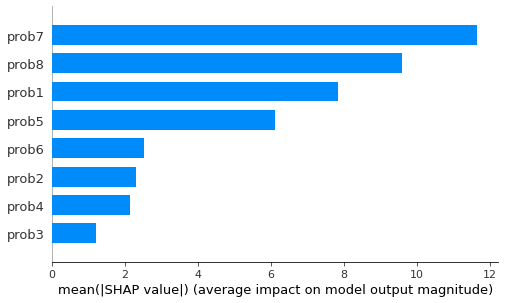

In [26]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [27]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X.iloc[:1000,:])

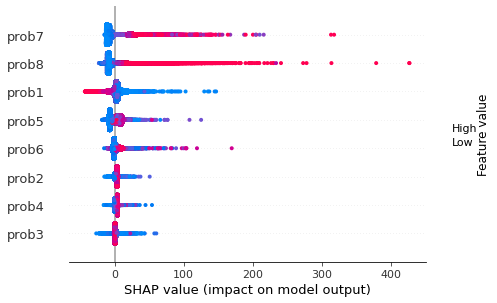

In [29]:
shap.summary_plot(shap_values, X)

#### Desa visualize

In [17]:
df_fin["jk_pred"] = xgb_model_basic.predict(X)
df_fin["iddesa"] = df_fin["idsls"].apply(str).str[0:10]
df_fin_desa = df_fin.groupby(["iddesa"]).agg({
    'jk' : sum,
    'jk_pred' :sum
    
})

In [18]:
df_fin_desa["residual"] = df_fin_desa.jk_pred -df_fin_desa.jk 

In [22]:
df_fin_desa

,jk,jk_pred,residual
iddesa,,,
3201010001,2715,2588.761230,-126.238770
3201010002,3047,2779.354004,-267.645996
3201010003,3509,2764.339355,-744.660645
3201010004,2918,3102.877930,184.877930
3201010005,2411,2089.248047,-321.751953
...,...,...,...
3279040002,3298,2991.031006,-306.968994
3279040003,3235,2977.730957,-257.269043
3279040004,3267,3102.391113,-164.608887


In [20]:
jabar = gpd.read_file("C:/Data/kuliah/Tesis/GGE tesis/Polygon/DESA_32/desa_32.shp")

In [21]:
jabar["iddesa"]  = jabar.kdprov +jabar.kdkab+jabar.kdkec+jabar.kddesa
jabar["iddesa"]  = jabar["iddesa"].apply(str)

In [23]:
jabar = jabar.set_index('iddesa').join(df_fin_desa, how='left')

In [25]:
jabar.shape

(5963, 14)

<AxesSubplot:>

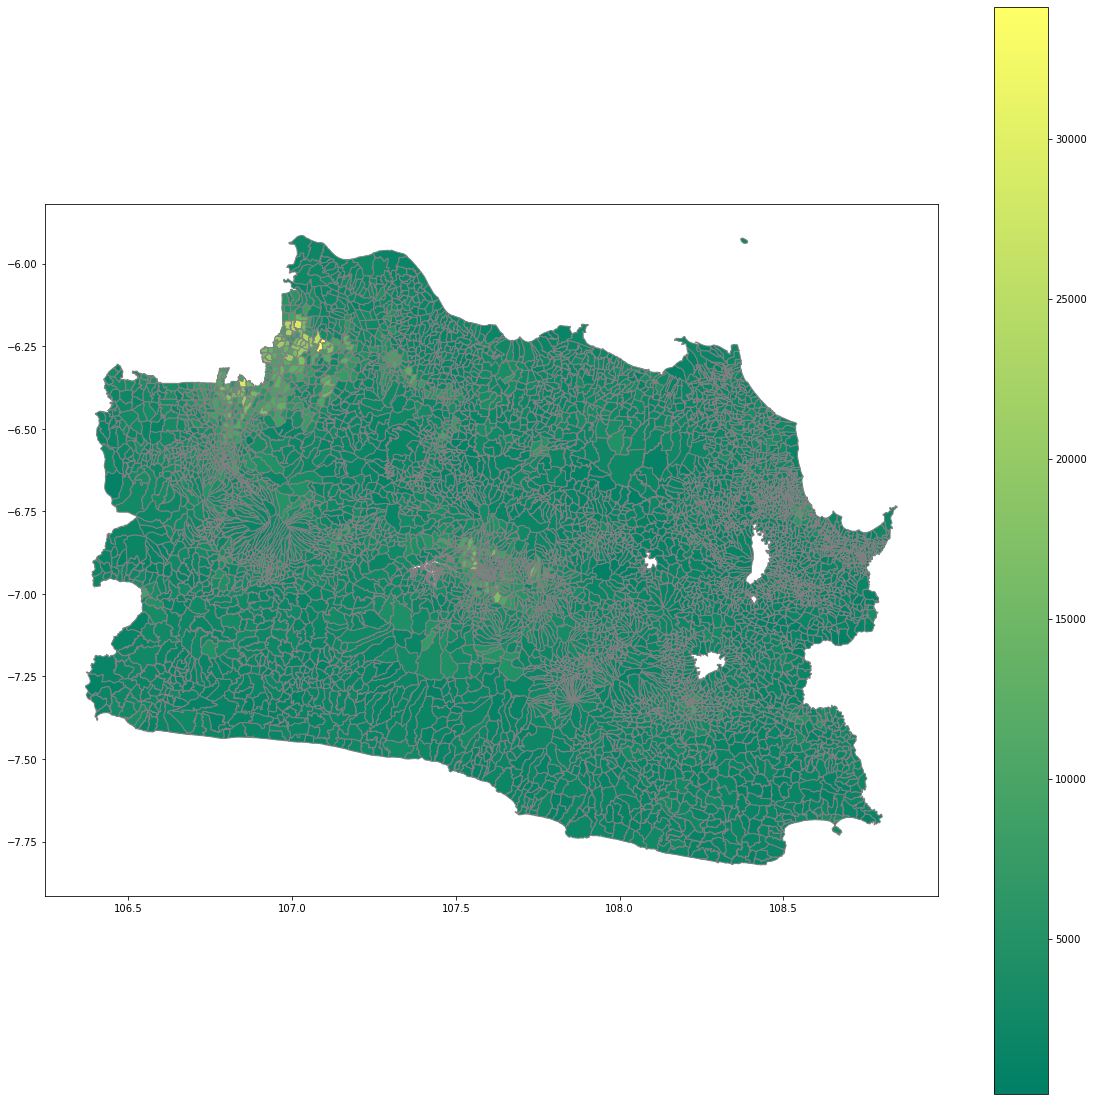

In [43]:
### True Value
jabar.plot(column='jk', figsize=(20, 20), legend=True, edgecolor='grey',cmap ="summer" )

<AxesSubplot:>

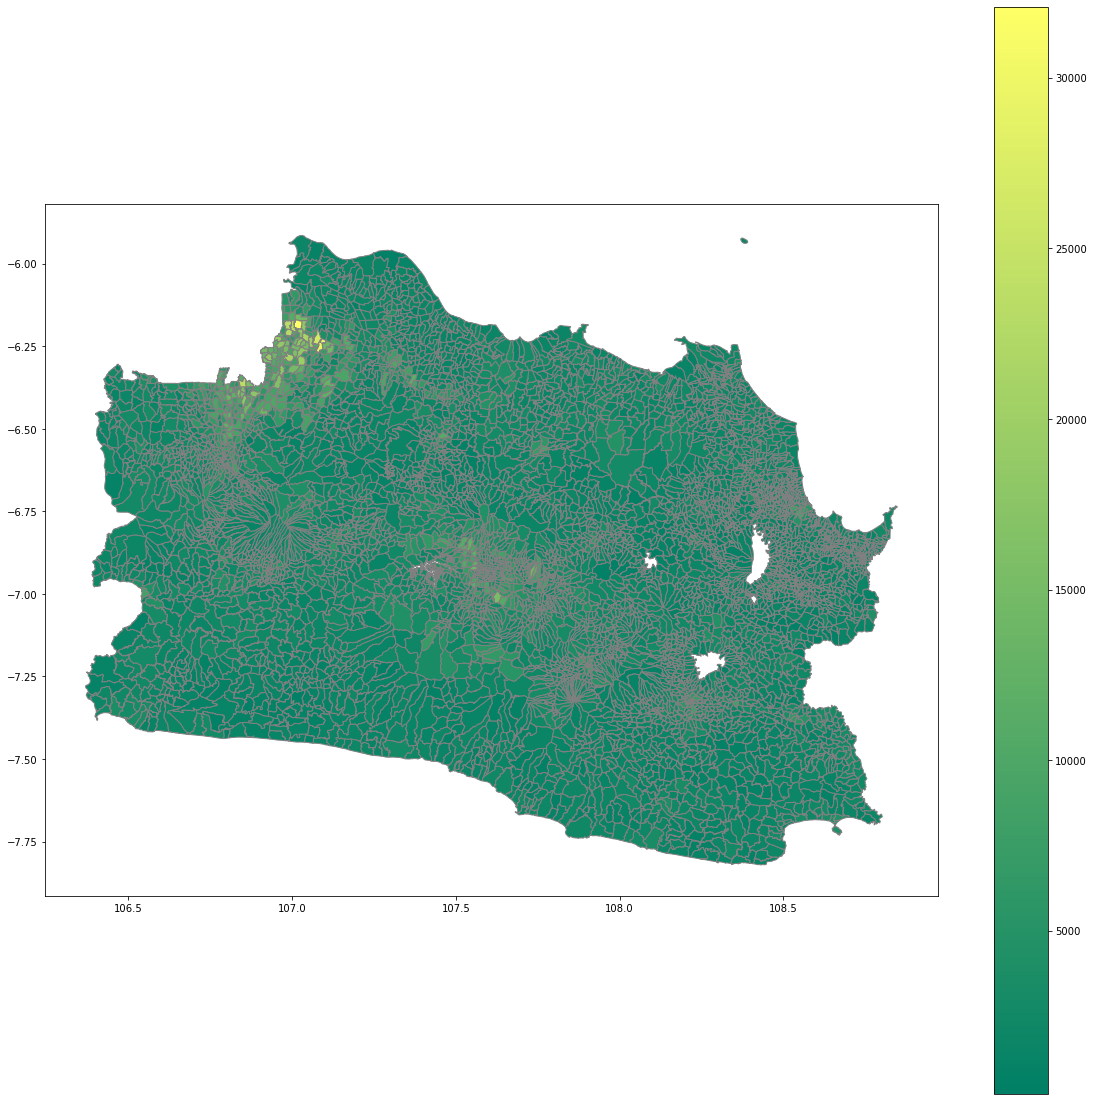

In [44]:
### Pred Value
jabar.plot(column='jk_pred', figsize=(20, 20), legend=True, edgecolor='grey',cmap ="summer" )

In [49]:
jabar["residual"] =jabar["residual"].abs()  

<AxesSubplot:>

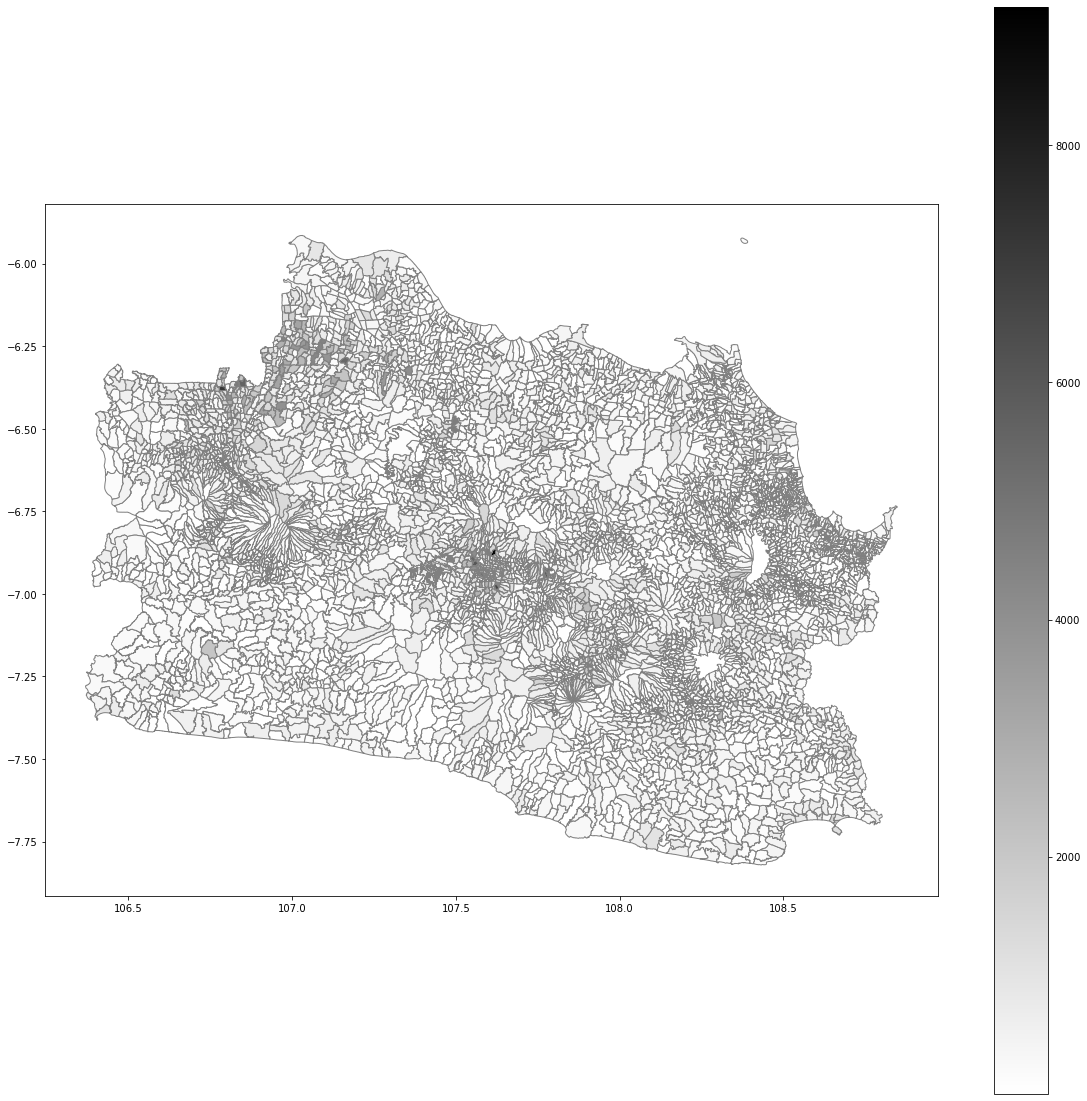

In [50]:
### residual
jabar.plot(column='residual', figsize=(20, 20), legend=True, edgecolor='grey',cmap ="binary" )

In [51]:
sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")
sls["iddesa"] = sls["iddesa"].apply(str)
desa = sls.groupby('iddesa').agg({'klas_ur' :'max', 'j_kk' :'sum'})

Columns (19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.


In [56]:
dfmae = df_fin_desa.join(desa)

In [57]:
dfmae

,jk,jk_pred,residual,klas_ur,j_kk
iddesa,,,,,
3201010001,2715,2588.761230,-126.238770,2,2715
3201010002,3047,2779.354004,-267.645996,2,3319
3201010003,3509,2764.339355,-744.660645,1,3861
3201010004,2918,3102.877930,184.877930,2,2918
3201010005,2411,2089.248047,-321.751953,1,2411
...,...,...,...,...,...
3279040002,3298,2991.031006,-306.968994,1,3298
3279040003,3235,2977.730957,-257.269043,1,3235
3279040004,3267,3102.391113,-164.608887,1,3267


In [58]:
dfmae_urban = dfmae[dfmae.klas_ur == 1]

In [61]:
dfmae_rural = dfmae[dfmae.klas_ur == 2]

In [62]:
print("MAE Urban : ", mae(dfmae_urban.jk, dfmae_urban.jk_pred))

MAE Urban :  447.26430922698086


In [63]:
print("MAE Rural : ", mae(dfmae_rural.jk, dfmae_rural.jk_pred))

MAE Rural :  275.1620401228665


In [65]:
print("Mean Urban : ", dfmae_urban.jk.mean())

Mean Urban :  2859.2633294528523


In [69]:
print("Mean Rural : ", dfmae_rural.jk.mean())

Mean Rural :  1391.8808664259927


In [68]:
print("MAE : ", mae(dfmae.jk, dfmae.jk_pred))

MAE :  399.2478628192189


In [70]:
print("Mean : ", dfmae.jk.mean())

Mean :  2449.8643612556657
